# IMPORTING DATA AND LIBRARIES

In [14]:
import numpy as np
import pandas as pd

from sklearn import tree, ensemble, model_selection, metrics

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

import seaborn as sb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2022/train.csv
/kaggle/input/tabular-playground-series-may-2022/test.csv


In [34]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/test.csv')

# PREPARING FEW FUNCTIONS

In [32]:
def train_report_clf(model):
    
    model.fit(X_train, y_train)
    print(metrics.classification_report(y_test, model.predict(X_test)))
    
    return model
    
    
def predict_submit(model):
    
    test['target'] = model.predict(test.drop(['id', 'f_27'], axis = 1))
    test[['id','target']].to_csv('submission.csv', index = False)

# EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

900 000 rows, no null values, 3 different data types : integers (16 columns, 14 if excluding the target and the id), float (16 columns) and one string column.

In [4]:
train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


## 1. Eyes on target

In [5]:
train.target.value_counts()/len(train)

0    0.513512
1    0.486488
Name: target, dtype: float64

The training dataset is almost a well balanced (51% / 49%), which is good news !

## 2. Analyzing integers columns

In [6]:
integers = [x for x in train.columns if train[x].dtypes == 'int64' and x != "id" and x != "target"]

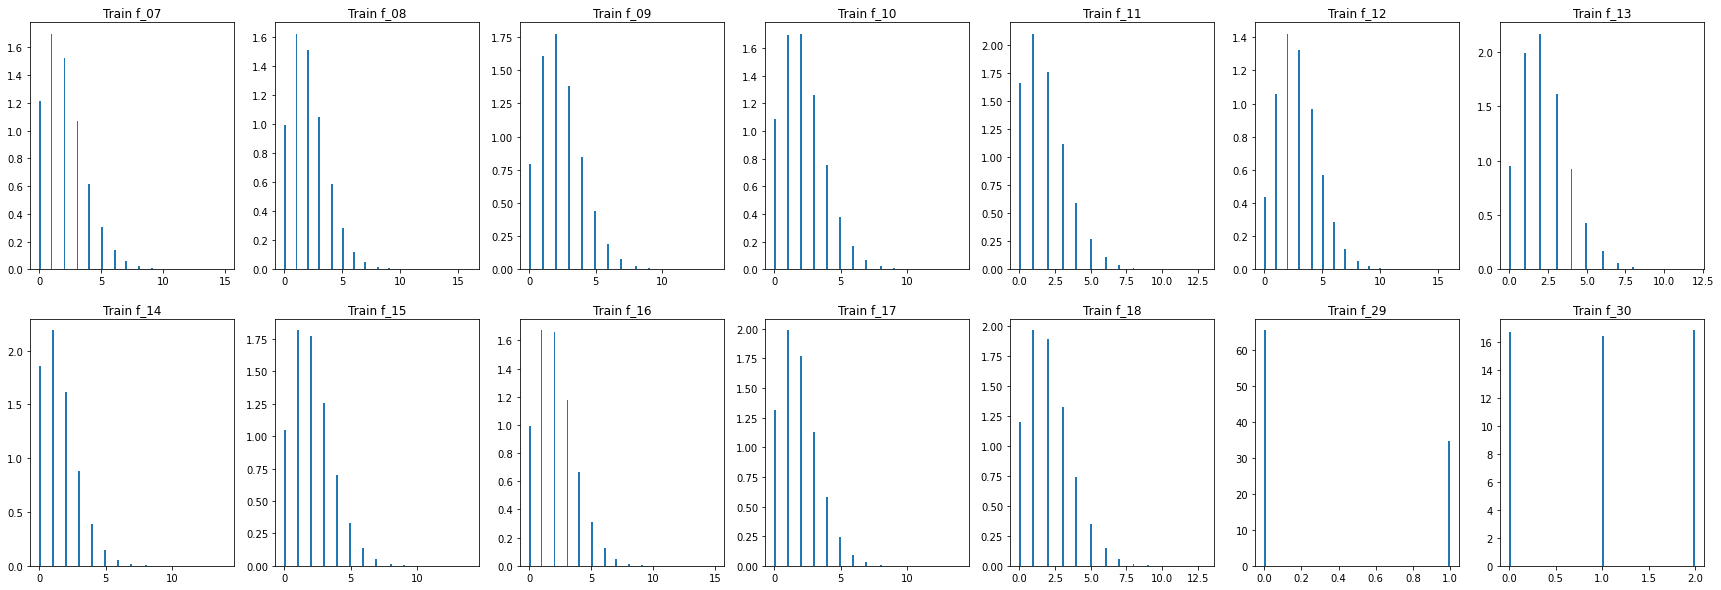

In [7]:
fig, axs = plt.subplots(2, 7, figsize=(30, 10))

for f, ax in zip(integers, axs.ravel()):
    ax.hist(train[f], density=True, bins=100)
    ax.set_title(f'Train {f}')
plt.show()

## 3. Analyzing floats columns

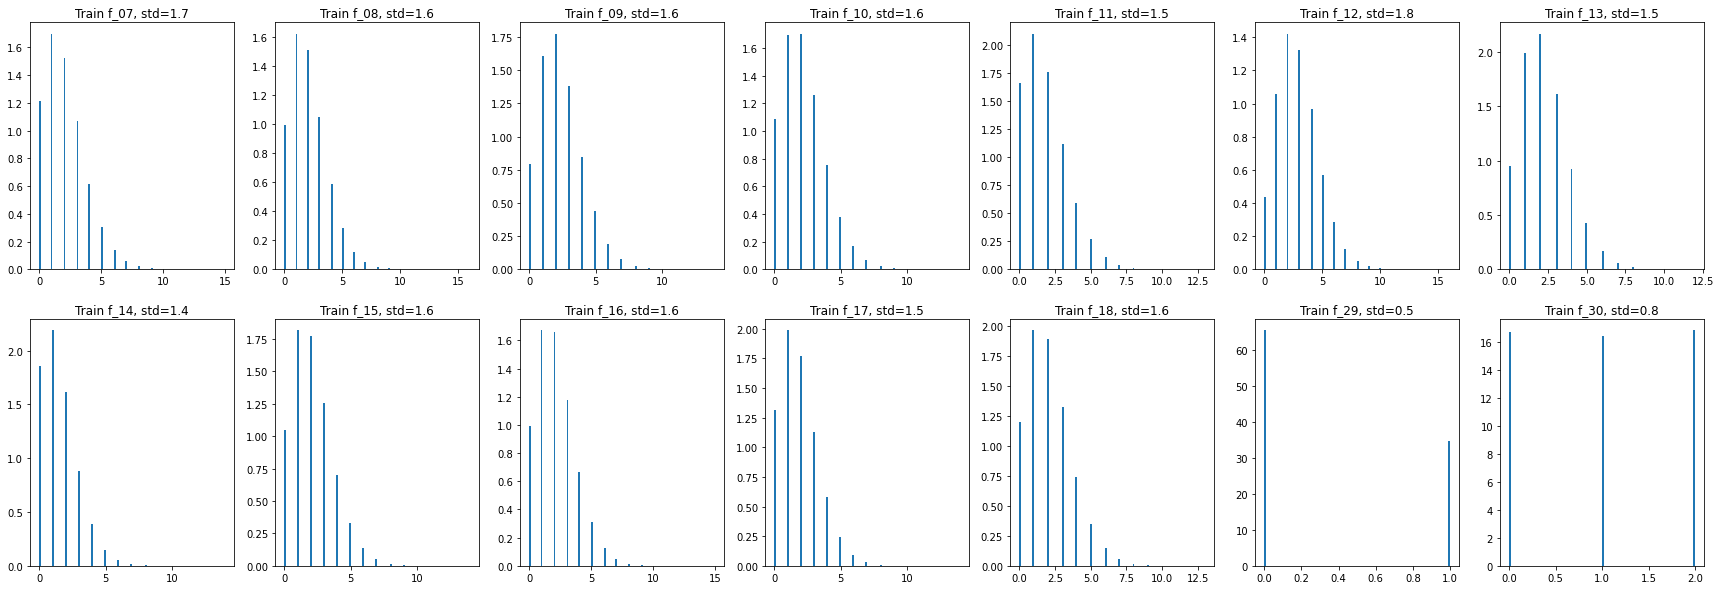

In [8]:
fig, axs = plt.subplots(2, 7, figsize=(30, 10))

for f, ax in zip(integers, axs.ravel()):
    ax.hist(train[f], density=True, bins=100)
    ax.set_title(f'Train {f}, std={train[f].std():.1f}')
plt.show()

## 4. What about the string column ?

# MODELING

Let's train a simple model to have a baseline score.

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train.drop(['id','target', 'f_27'], axis = 1), train.target, random_state=42)

In [20]:
baseline_clf = tree.DecisionTreeClassifier()

train_report_clf(baseline_clf)

In [25]:
print(metrics.classification_report(y_test, baseline_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73    115578
           1       0.72      0.72      0.72    109422

    accuracy                           0.73    225000
   macro avg       0.73      0.73      0.73    225000
weighted avg       0.73      0.73      0.73    225000



In [31]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
print(metrics.classification_report(y_test, xgb_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85    115578
           1       0.85      0.84      0.84    109422

    accuracy                           0.85    225000
   macro avg       0.85      0.85      0.85    225000
weighted avg       0.85      0.85      0.85    225000



In [35]:
predict_submit(xgb_clf)